In [1]:
from get_models import get_model as get_model

from keras import backend as K
import numpy as np

from Flickr30k.get_data import Flickr30kLoader
# from pascal50S.get_data_refactor import Pascal10SLoader 

import random

from CaptionImageEvaluator import *

from sklearn.manifold import TSNE
from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from termcolor import colored
from webcolors import rgb_percent_to_hex

from keras.preprocessing.sequence import pad_sequences

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot



/rds/user/yl538/hpc-work/PartIIIProject/tensorflow-env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
vae = get_model(2)
print(vae.model_name)
vae.define_model()
vae.load_epoch(120)
caption_image = CaptionImageEvaluator(
    vae, save_aux='VAE-EPOCH-120_hidden_1536')
caption_image.load_model(
    hidden_size=1536)
caption_image.train(load_epoch=60)

Found 17719 unique tokens.
bilstm_gauss_dilate_small_beta_1_flickr


60

In [49]:
img_keys = list(vae.data_loader.data_val.keys())
index = 11

img = img_keys[index:index+1]

input_captions = []

print(vae.data_loader.data_val[img[0]])

def append_random(input_captions):
    rand_key = random.choice(img_keys)
    rand_caption = random.choice(vae.data_loader.data_val[rand_key])
    input_captions.append(rand_caption)

input_captions.append('A child is sitting in a boat')
input_captions.append('A child is sitting in a train')
input_captions.append('A young boy getting ready for a day of fishing')
input_captions.append('An orange striped kitten is biting a girl on the nose')
append_random(input_captions)
append_random(input_captions)



input_images = img
input_images *= len(input_captions)

input_captions_tok = vae.tokenizer.texts_to_sequences(input_captions)
input_captions_tok = pad_sequences(input_captions_tok, maxlen=vae.MAX_SEQUENCE_LENGTH, padding='post')

input_images = vae.data_loader.get_images(input_images, 224, 224)
input_images /= 255.
input_images -= 0.5
input_images *= 2




['Two disabled bicyclists are racing three wheeled cycles that have been adapted for them .\n', 'Two people are racing with wheelchairs in a competition .\n', 'Two people compete in a wheelchair race on a city street .\n', 'Two men push three wheeled chairs up an inclining road .\n', 'Two handicapped men doing a race in their wheelchairs .\n']


In [18]:
import time
start = time.time()
predict_errors = caption_image.model.predict([input_captions_tok, input_images])
print(time.time()-start)
errors = caption_image.input_grads([input_captions_tok, input_images])
print(time.time()-start)

0.04567217826843262
0.13103437423706055


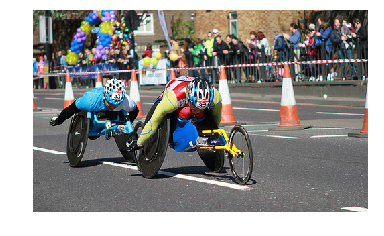

In [50]:
PATH = "Flickr30k/flickr30k_images/{}"
p = PATH.format(img[0])
image = mpimg.imread(p)
plt.gca().clear()
plt.imshow(image);
plt.axis('off')
plt.show()


In [154]:
from IPython.display import HTML as html_print, display
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

token_errors = np.sqrt(np.square(errors[0]).sum(axis=2))

from colour import Color
red_to_green_colors = list(Color('Green').range_to(Color("Red"),20))

def cstr(s, color):
    return "<text style=color:{}>{}</text>".format(color, s)

def get_error_color(input_caption, token_error, predict_error):
    
#     print(token_error)
    green = np.asarray((0, 255, 0))
    red = np.asarray((255.0, 0, 0))
    colored_token = []
    
    
    token_error = token_error[:len(input_caption.split(" "))]
    
    token_error = np.log(token_error)
    token_error *= (1-predict_error[0])
    
    min_error = np.min(token_error)
    max_error = np.max(token_error)
    
#     print(token_error)
    
    for token, error in zip(input_caption.split(" "), token_error):
        
        error_scale = 1/(max_error-min_error)*error - min_error/(max_error-min_error)
        error_scale *= (1-predict_error[0])
    
        
        index = min(int(round(len(red_to_green_colors)*error_scale)), len(red_to_green_colors)-1)
        colored_token.append(cstr(token, color=red_to_green_colors[index]))
        
    return colored_token

for i in range(len(input_captions)):
    colored_tokens = get_error_color(input_captions[i], token_errors[i], predict_errors[i])
    display(html_print(' '.join(colored_tokens)))
    
print(predict_errors)
    

[[0.59838516]
 [0.10757636]
 [0.67342573]
 [0.1055553 ]
 [0.1851255 ]
 [0.12290924]]
